In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter, GlobalObjective
from refnx.reflect import SLD, Slab, ReflectModel#, LipidLeaflet
from refnx.reflect import LipidLeaflet as LipidLeafletNoProtein
# from sepObjectiveGO import getObjective as gO
# import make_sim_data as msd
# import lipidBilayerAsGiven.SLD_maker 
import data_in as di
from protein.ProteinBuiltOnLL3 import LipidLeafletWithProtien as LipidLeaflet
from protein.protrusion2 import Protrusion

from refnx._lib import flatten
from refnx._lib import unique as f_unique

print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))
%matplotlib inline
SEED = 12345

refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4


csv
cvs-collecting
csv
cvs-collecting
csv
cvs-collecting


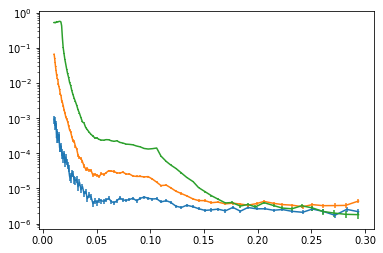

In [2]:
# dataD2o = Data1D(data=di.data_in("lipidBilayerData/54696_97_edit.txt"))
# dataD2o.name="d2o"
# dataPmw = Data1D(data=di.data_in("lipidBilayerData/54699_00_edit.txt"))
# dataPmw.name="pmw"

dataAcmw = Data1D(data=di.data_in("protein/54613_14edit.txt"))
dataAcmw.name="acm"
dataPmw = Data1D(data=di.data_in("protein/54616_17edit.txt"))
dataPmw.name="pmw"
dataD2o = Data1D(data=di.data_in("protein/10_11_d2o.txt"))
dataD2o.name="d2o"
plt.errorbar(dataAcmw.data[0],dataAcmw.data[1],dataAcmw.data[2])
plt.errorbar(dataPmw.data[0],dataPmw.data[1],dataPmw.data[2])
plt.errorbar(dataD2o.data[0],dataD2o.data[1],dataD2o.data[2])
plt.yscale("log")
plt.show()

In [3]:
name = "bilayer"

d2o = SLD(6.34, "D2O")
pmw = SLD(2.35, "Protein Matched Water")
acmw = SLD(0.00, "ACMW")
air = SLD(0.00, "Air")

d2o.real.setp(vary=True, bounds=(5.35, 6.35)) # bounds=(5.9, 6.35))
pmw.real.setp(vary=True, bounds=(1.35, 3.35))
acmw.real.setp(vary=True, bounds=(-0.56, 1))

apm = Parameter(value=50, name='%s - area_per_molecule' % name,
                bounds=(25, 100), vary=True)

#Define all the neutron b's
bc = 0.6646e-4  #Carbon
bo = 0.5804e-4  #Oxygen
bh = -0.3739e-4 #Hydrogen
bp = 0.513e-4   #Phosphorus
bn = 0.936e-4   #Nitrogen
bd = 0.6671e-4  #Deuterium

#Formulae of the molecule sections...
CH2 = (1*bc) + (2*bh)
CH = (1*bc) + (1*bh)
CH3 = (1*bc) + (3*bh)
D2O = (2*bd) + (1*bo)
H2O = (2*bh) + (1*bo)

# Calculate mole fraction of D2O from the bulk SLD..
# d2o_molfr = (1/D2O-H2O)*(contrast*27.64)-H2O
# wMol = (d2o_molfr * D2O) + ((1-d2o_molfr)*H2O)

#sum b's of all the different fragments
b_tails = Parameter(value=(28*CH2) + (2*CH) + (2*CH3),
                       name='%s - b_tails_real' % name)

sum_popc_heads = (8*bo) + (1*bp) + (1*bn) + (2*bc) + (4*CH2) + (3*CH3) + (1*CH)
sum_popg_heads = (10*bo) + (1*bp) + (2*bc) + (4*CH2) + (2*CH) + (2*bh)
b_heads = Parameter(value=(3*(sum_popc_heads) + (sum_popg_heads))/4,
                        name='%s - b_heads_real' % name)

#monolayer compositions
#sum_m_tails = (34*CH2) + (2*CH3);
#sum_m_heads = (1*bn) + (2*CH3) + (Waters_per_headD * wMol);

#volumes of each fragment
vCH2 = 27.7
nCH2 = 30
vCH3 = 54.6
vm_tails = Parameter(value=(nCH2 * vCH2) + (2 * vCH3),
            name='%s - volume_tails' % name) #
vm_heads = Parameter(value=331,
            name='%s - volume_heads' % name)  #
vm_water = Parameter(value=29.7,
            name='%s - water_vm' % name)

#thickness
thickness_tails = Parameter(11, # 6., #value=vm_tails.value/apm.value,
            name='%s - thickness_tails' % name,# vary=False)
            bounds=(1,30),  #3, #(1-0.75)*vm_tails.value/apm.value,
                      #9), #(1+0.75)*vm_tails.value/apm.value),
               vary=True)
thickness_heads = Parameter(value= 6, #11., #vm_heads.value/apm.value,
            name='%s - thickness_heads' % name,# vary=False)
            bounds=(1,30),  #  9, #(1-0.75)*vm_heads.value/apm.value,
                      # 20), #(1+0.75)*vm_heads.value/apm.value),
               vary=True)

rough_head_tail = Parameter(value=2,
            name='%s - roughs' % name,
            bounds=(0,10), vary=True)

rough_top = Parameter(value=2,
            name='%s - roughs' % name,
            bounds=(0,10), vary=True)
# rough_bot = rough_top
# rough_head_ = Parameter(value=2.0,
#             name='%s - rough_bot' % name,
#             bounds=(0,10), vary=True)

waters_head_frac = Parameter(
            value=0.25,
            name="{} - Waters Head fraction".format(name),
            bounds=(0, 0.5), vary=True)

waters_tail_frac = Parameter(
            value=0.25,
            name="{} - Waters Tail fraction".format(name),
            bounds=(0, 0.5), vary=True)

# b_mscl = Parameter(
#             value= ,
#             name="{} - b_protein_real".format(name),
#             vary=False)

vm_mscl = Parameter(
            value=74937.5 + 19749,
            name="{} - volume_protein".format(name),
            vary=False)

PLRatio = Parameter(
            value= 0.75,
            name="{} - ratio protein to bilayer".format(name),
            bounds=(0, 1),vary=True)


In [4]:
# apm, b_heads, vm_heads, thickness_heads
# b_tails, vm_tails, thickness_tails, rough_head_tail
# rough_preceding_mono, head_solvent

# apm, b_heads, vm_heads, thickness_heads,
#  b_tails, vm_tails, thickness_tails, rough_head_tail,
#  rough_preceding_mono,
#  waters_head_frac, waters_tail_frac,
#  vm_mscl, PLRatio,
#  head_solvent=None, tail_solvent=None,
#  reverse_monolayer=False, name=''

# head_solvent_d2o = SLD(6.07, "D2O in bilayer")
# head_solvent_d2o.real.setp(6.07, vary=True, bounds=(5.35, 6.35))
upper_lipid_d2o = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_top, rough_top,
#     waters_head_frac, waters_tail_frac,
   vm_mscl, PLRatio,
                               d2o, d2o,
    reverse_monolayer=False, name="upper_lipid_d2o")

lower_lipid_d2o = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_top, rough_top,
#     waters_head_frac, waters_tail_frac,
    vm_mscl, PLRatio,
                               d2o, d2o,
    reverse_monolayer=True, name="lower_lipid_d2o")


# head_solvent_pmw = SLD(2.35, "Protein Matched Water in bilayer")
# head_solvent_pmw.real.setp(2.34, vary=True, bounds=(1.35, 3.35))
upper_lipid_pmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_top, rough_top,
#     waters_head_frac, waters_tail_frac,
    vm_mscl, PLRatio,
                               pmw, pmw,
    reverse_monolayer=False, name="upper_lipid_pmw")

lower_lipid_pmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_top, rough_top,
#     waters_head_frac, waters_tail_frac,
   vm_mscl, PLRatio,
                               pmw, pmw,
    reverse_monolayer=True, name="lower_lipid_pmw")


upper_lipid_acmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_top, rough_top,
#     waters_head_frac, waters_tail_frac,
    vm_mscl, PLRatio,
                                acmw, acmw,
    reverse_monolayer=False, name="upper_lipid_acmw")

lower_lipid_acmw = LipidLeaflet(apm, b_heads, vm_heads, thickness_heads,
    b_tails, vm_tails, thickness_tails, rough_top, rough_top,
#     waters_head_frac, waters_tail_frac,
    vm_mscl, PLRatio,
                                acmw, acmw,
    reverse_monolayer=True, name="lower_lipid_acmw")

In [5]:
name_m = "mono, dodab"
# APMD = Parameter(value=48, name='%s - area_per_molecule' % name_m,
#         bounds=(40,200), vary=True)

# # monolayer compositions
# m_tails = Parameter(value=(34*CH2) + (2*CH3),
#             name='%s - b_tails_real' % name_m)
# m_heads = Parameter(value=(1*bn) + (2*CH3),
#             name='%s - b_heads_real' % name_m)

# # monolayer volumes
# vm_m_tails = Parameter(value=vCH2*36,
#             name='%s - volume_tails' % name_m)
# vm_m_heads = Parameter(value=54.6,
#             name='%s - volume_heads' % name_m)

# # monolayer thicknesses
# tail_thick_m = Parameter(value=vm_m_tails.value / APMD.value,
#             name='%s - thickness_tails' % name_m,
#             bounds=(1,#(1-0.75)*vm_m_tails.value / APMD.value,
#                     30),#(1+0.75)*vm_m_tails.value / APMD.value),
#                vary=True)
# head_thick_m = Parameter(value=vm_m_heads.value / APMD.value,
#             name='%s - thickness heads' % name_m,
#             bounds=(1,#(1-0.75)*vm_m_heads.value / APMD.value,
#                     30),#(1+0.75)*vm_m_heads.value / APMD.value),
#                vary=True)

# roughness_m =  Parameter(value=5.8,
#             name='%s - roughness' % name_m,
#             bounds=(0,10), vary=True)

In [6]:
# firstlayerd = SLD(0, "d20 first layer")
# firstlayerd.real.setp(vary=True, bounds=(-1, 6.35))
# firstlayerp = SLD(0, "pmw first layer")
# firstlayerp.real.setp(vary=True, bounds=(-1, 6.35))
# firstlayera = SLD(0, "acmw first layer")
# firstlayera.real.setp(vary=True, bounds=(-1, 6.35))
# secondlayerd = SLD(0, "d20 second layer")
# secondlayerd.real.setp(vary=True, bounds=(-1, 6.35))
# secondlayerp = SLD(0, "pmw second layer")
# secondlayerp.real.setp(vary=True, bounds=(-1, 6.35))
# secondlayera = SLD(0, "acmw second layer")
# secondlayera.real.setp(vary=True, bounds=(-1, 6.35))

# m_air_in_tail = air
# m_head_solvent_d2o = d2o
# m_head_solvent_pmw = pmw
# # m_head_solvent_acmw = acmw
# dodab_solv = SLD(0.00, "dodab solv in tail")
# dodab_solv.real.setp(vary=True, bounds=(-1, 6.35))

# dodab_d2o = LipidLeafletNoProtein(apm=APMD, b_heads=m_heads, vm_heads=vm_m_heads,
# thickness_heads=head_thick_m, b_tails=m_tails, vm_tails=vm_m_tails,
# thickness_tails=tail_thick_m, rough_head_tail=roughness_m,
# rough_preceding_mono=roughness_m, head_solvent=m_head_solvent_d2o, tail_solvent=dodab_solv,
#                                   reverse_monolayer=True) #mono

# dodab_pmw = LipidLeafletNoProtein(apm=APMD, b_heads=m_heads, vm_heads=vm_m_heads,
# thickness_heads=head_thick_m, b_tails=m_tails, vm_tails=vm_m_tails,
# thickness_tails=tail_thick_m, rough_head_tail=roughness_m,
# rough_preceding_mono=roughness_m, head_solvent=m_head_solvent_pmw, tail_solvent=dodab_solv,
#                                   reverse_monolayer=True) #mono

# dodab_acmw = LipidLeafletNoProtein(apm=APMD, b_heads=m_heads, vm_heads=vm_m_heads,
# thickness_heads=head_thick_m, b_tails=m_tails, vm_tails=vm_m_tails,
# thickness_tails=tail_thick_m, rough_head_tail=roughness_m,
# rough_preceding_mono=roughness_m, head_solvent=m_head_solvent_acmw, tail_solvent=m_air_in_tail,
#                                   reverse_monolayer=True) #mono

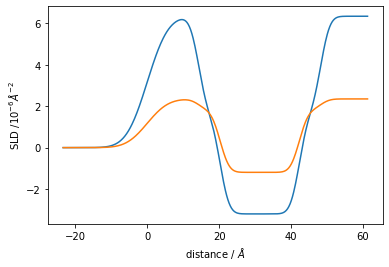

________________________________________________________________________________
Parameters: 'Structure - d2o'
________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'Air - sld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:      'D2O'     
<Parameter:'thickness_solution', value=14.3          , bounds=[6, 25]>
<Parameter:  'D2O - sld'  , value=6.34          , bounds=[5.35, 6.35]>
<Parameter: 'D2O - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'rough_preceding_solution', value=4.6          , bounds=[0, 20]>
<Parameter:'D2O - volfrac solvent', value=0

<Parameter:'Protein Matched Water - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>


In [7]:
# to changing to
solution_thickness = Parameter(value=14.3, bounds=(6, 25), vary=True,
            name='thickness_solution')
# solution_thickness2 = Parameter(value=14.3, bounds=(6, 25), vary=True,
#             name='thickness_solution2')

# rough_preceding_solution = Parameter(value=4.6, bounds=(0, 20), vary=True,
#             name='rough_preceding_solution')


rough_preceding_solution = Parameter(value=4.6, bounds=(0, 20), vary=True,
            name='rough_preceding_solution')#, constraint=)

# dodab_thick1 = Parameter(value=14.3, bounds=(0.1, 25), vary=True,
#             name='thickness_solution')
# dodab_thick2 = Parameter(value=14.3, bounds=(0.1, 25), vary=True,
#             name='thickness_solution')

structure_d2o  = air(0, 0) | d2o(solution_thickness, rough_preceding_solution)  | upper_lipid_d2o  | lower_lipid_d2o  | d2o(solution_thickness, rough_top)
structure_pmw  = air(0, 0) | pmw(solution_thickness, rough_preceding_solution)  | upper_lipid_pmw  | lower_lipid_pmw  | pmw(solution_thickness, rough_top)
structure_acmw = air(0, 0) | acmw(solution_thickness, rough_preceding_solution) | upper_lipid_acmw | lower_lipid_acmw | acmw(solution_thickness, rough_top)

# structure_d2o  = air(0, 0) | d2o(solution_thickness, rough_preceding_solution)  | upper_lipid_d2o  | lower_lipid_d2o  | d2o(solution_thickness, rough_preceding_solution)
# structure_pmw  = air(0, 0) | pmw(solution_thickness, rough_preceding_solution)  | upper_lipid_pmw  | lower_lipid_pmw  | pmw(solution_thickness, rough_preceding_solution)
# structure_acmw = air(0, 0) | acmw(solution_thickness, rough_preceding_solution) | upper_lipid_acmw | lower_lipid_acmw | acmw(solution_thickness, rough_preceding_solution)

structure_d2o.name = "d2o"
structure_pmw.name = "protein matched water"
# structure_acmw.name = "ACMW"

plt.plot(*structure_d2o.sld_profile(),label="structure_d2o")
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$')
plt.plot(*structure_pmw.sld_profile(),label="structure_pmw")
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$')
# plt.plot(*structure_acmw.sld_profile(),label="structure_acmw")
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$')
plt.show();
print(structure_d2o.parameters)
print(structure_pmw.parameters)
# print(structure_acmw.parameters)

In [8]:
# right_protrusion_d2o.parameters

In [9]:
# print(structure_acmw.slabs())
# print(structure_pmw.slabs())
# print(structure_d2o.slabs())

def logp_extra(model=None, data=None):
    returns = 0
#     if rough_top.value > thickness_heads.value:
#         returns += -np.inf
#         print("rough, thickness: ", rough_top.value, thickness_heads.value)
    if choose==2:
        if upper_lipid_d2o.logp() == -np.inf or upper_lipid_pmw.logp() == -np.inf or upper_lipid_acmw.logp() == -np.inf:
            returns += -np.inf
    return returns


In [10]:
scale=0.5538
print(dataD2o.y.max(), dataPmw.y.max())#, dataAcmw.y.max())
print(dataD2o.y.min(), dataPmw.y.min())#, dataAcmw.y.min())
model1 = ReflectModel(structure_d2o)
model1.scale.setp(scale, vary=True, bounds=(0, 1))#0.25, 1)) #1./dataD2o.y.max()
if dataD2o.y.min()<0:
    d2oUpBound = dataD2o.y.min() * 0.2
    d2oLoBound = dataD2o.y.min() * 1.8
else:
    d2oUpBound = dataD2o.y.min() * 1.8
    d2oLoBound = dataD2o.y.min() * 0.2
model1.bkg.setp(dataD2o.y.min(),vary=True,bounds=(d2oLoBound, d2oUpBound))

model2 = ReflectModel(structure_pmw)
model2.scale.setp(scale, vary=True, bounds=(0, 1))#0.25, 1))#(1./dataPmw.y.max(), vary=False)
if dataPmw.y.min()<0:
    pmwUpBound = dataPmw.y.min() * 0.2
    pmwLoBound = dataPmw.y.min() * 1.8
else:
    pmwUpBound = dataPmw.y.min() * 1.8
    pmwLoBound = dataPmw.y.min() * 0.2
model2.bkg.setp(dataPmw.y.min(),vary=True,bounds=(pmwLoBound, pmwUpBound))

model3 = ReflectModel(structure_acmw)
model3.scale.setp(scale, vary=True, bounds=(0, 1))#0.25, 1)) #1./dataAcmw.y.max(), vary=False)
if dataAcmw.y.min()<0:
    acmwUpBound = dataAcmw.y.min() * 0.2
    acmwLoBound = dataAcmw.y.min() * 1.8
else:
    acmwUpBound = dataAcmw.y.min() * 1.8
    acmwLoBound = dataAcmw.y.min() * 0.2
model3.bkg.setp(dataAcmw.y.min(),vary=True,bounds=(acmwLoBound, acmwUpBound))



objective1 = Objective(model1, dataD2o, transform=Transform("logY"))#, logp_extra =logp_extra)
objective2 = Objective(model2, dataPmw, transform=Transform("logY"))#, logp_extra =logp_extra)
objective3 = Objective(model3, dataAcmw, transform=Transform("logY"))#, logp_extra =logp_extra)
gobjective = GlobalObjective([objective1,objective2,objective3])
gobjective.logp_extra = logp_extra

0.562 0.0655
1.8e-06 3.02e-06


In [11]:
print("")
print("logp:",gobjective.logp())
[[print(i,param.name+":",param.value, param.bounds,"logp:", param.logp())] for i,param in enumerate(gobjective.varying_parameters())];
# print
# [[print(i,param)] for i,param in enumerate(gobjective.parameters)];# if "area_per_molecule" in param.name];
# gobjective.parameters
print()
# [[print(i,param.name)] for i,param in enumerate(gobjective.parameters)];# if "area" in param
list(print(p) for p in f_unique(flatten(gobjective.parameters)) if "thi" in p.name or "ap" in p.name);
# upper_lipid_d2o.done()


logp: -inf
0 scale: 0.5538 [0, 1] logp: 0.0
1 bkg: 1.8e-06 [3.6e-07, 3.24e-06] logp: 12.75772026381642
2 thickness_solution: 14.3 [6, 25] logp: -2.9444389791664407
3 D2O - sld: 6.34 [5.35, 6.35] logp: 0.0
4 rough_preceding_solution: 4.6 [0, 20] logp: -2.995732273553991
5 bilayer - area_per_molecule: 50.0 [25, 100] logp: -4.31748811353631
6 bilayer - thickness_heads: 6.0 [1, 30] logp: -3.367295829986474
7 bilayer - thickness_tails: 11.0 [1, 30] logp: -3.367295829986474
8 bilayer - roughs: 2.0 [0, 10] logp: -2.3025850929940455
9 bilayer - ratio protein to bilayer: 0.75 [0, 1] logp: 0.0
10 scale: 0.5538 [0, 1] logp: 0.0
11 bkg: 3.02e-06 [6.040000000000001e-07, 5.436e-06] logp: 12.24025009733176
12 Protein Matched Water - sld: 2.35 [1.35, 3.35] logp: -0.6931471805599453
13 scale: 0.5538 [0, 1] logp: 0.0
14 bkg: 1.73e-06 [3.46e-07, 3.114e-06] logp: 12.79738552020885
15 ACMW - sld: 0.0 [-0.56, 1] logp: -0.4446858212614458

<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<

In [12]:
%%time
choose = 2
place = "LipidLeafletProtein1"
if choose==0:
    fitter = CurveFitter(gobjective)
    res = fitter.fit("differential_evolution", target="nlpost")#, seed=SEED)
if choose==1:
    fitter = CurveFitter(gobjective)
    fitter.sample(400)
    fitter.reset()
    res = fitter.sample(15, nthin=100)
if choose==2:
    from dynesty import DynamicNestedSampler
    from dynesty import plotting as dyplot
    from CFitter2 import CFitter
    fitter = CFitter(gobjective)
    # DynamicNestedSampler
    DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
    DNSampler.run_nested(dlogz_init=0.05) # was 0.01
    res1 = DNSampler.results
    from dynesty import plotting as dyplot
    from saveDynestyRun import save_obj
    save_obj(res1, place)
    fitter.logl(fitter._best)
    save_obj(fitter, place+"fitter")
if choose==3:
    from saveDynestyRun import load_obj
    from dynesty import plotting as dyplot
    res1 = load_obj(place)
    fitter = load_obj(place+"fitter")
    fitter.logl(fitter._best)
    gobjective = fitter.objective
print("done")


1341it [02:21,  4.87it/s, batch: 0 | bound: 0 | nc: 62 | ncall: 12942 | eff(%):  9.976 | loglstar:   -inf < -63344.348 <    inf | logz: -63353.936 +/-    nan | dlogz: 51017.236 >  0.050] C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
10736it [1:01:36,  2.49it/s, batch: 0 | bound: 141 | nc: 25 | ncall: 248755 | eff(%):  4.307 | loglstar:   -inf < -796.502 <    inf | logz: -822.453 +/-    nan | dlogz: 423.225 >  0.050] C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
11934it [1:09:09,  2.96it/s, batch: 0 | bound: 160 | nc: 25 | ncall: 280276 | eff(%):  4.250 | loglstar:   -inf < -555.854 <

14755it [1:28:18,  3.30it/s, batch: 0 | bound: 216 | nc: 25 | ncall: 373216 | eff(%):  3.948 | loglstar:   -inf < -247.320 <    inf | logz: -280.282 +/-    nan | dlogz: 147.086 >  0.050] C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
14756it [1:28:24,  2.01s/it, batch: 0 | bound: 217 | nc: 547 | ncall: 373763 | eff(%):  3.943 | loglstar:   -inf < -247.272 <    inf | logz: -280.218 +/-    nan | dlogz: 147.018 >  0.050]C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:241: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
14936it [1:29:55,  3.04it/s, batch: 0 | bound: 220 | nc: 25 | ncall: 381050 | eff(%):  3.915 | loglstar:   -inf < -235.452 <    inf 

17778it [1:50:06,  3.09it/s, batch: 0 | bound: 272 | nc: 25 | ncall: 480520 | eff(%):  3.696 | loglstar:   -inf < -104.589 <    inf | logz: -142.836 +/-    nan | dlogz: 67.424 >  0.050]  C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:241: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
18040it [1:52:01,  3.10it/s, batch: 0 | bound: 277 | nc: 25 | ncall: 489907 | eff(%):  3.679 | loglstar:   -inf < -97.124 <    inf | logz: -135.705 +/-    nan | dlogz: 63.044 >  0.050]   C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be ex

22784it [2:19:25,  3.84it/s, batch: 0 | bound: 355 | nc: 25 | ncall: 646263 | eff(%):  3.523 | loglstar:   -inf < -19.463 <    inf | logz: -66.213 +/-    nan | dlogz: 21.472 >  0.050]  C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:241: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
23328it [2:22:32,  3.65it/s, batch: 0 | bound: 364 | nc: 25 | ncall: 664338 | eff(%):  3.509 | loglstar:   -inf < -15.258 <    inf | logz: -62.893 +/-    nan | dlogz: 20.590 >  0.050]  C:\Users\John\Anaconda3\envs\refnx\lib\site-packages\dynesty\sampling.py:219: UserWarning: Random number generation appears to be extrem

done
Wall time: 4h 45min 36s


In [13]:
# print(gobjective.parameters,"\n++++++++++++++++++++++++++++++++++++++++++++++++++++")
# fitter.logl(fitter._best)

[[print(param)] for param in gobjective.parameters]#varying_parameters()]

[[print(param)] for param in gobjective.varying_parameters()];

________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=0.549203          , bounds=[0, 1]>
<Parameter:     'bkg'     , value=1.11351e-06          , bounds=[3.6e-07, 3.24e-06]>
<Parameter:'dq - resolution', value=5 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - d2o'
________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'Air - sld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:'Air - volfrac solvent', value=0 (fixed)  , bounds=[

<Parameter:'Protein Matched Water - volfrac solvent', value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=0.143298          , bounds=[0, 1]>
<Parameter:     'bkg'     , value=2.66825e-06          , bounds=[3.46e-07, 3.114e-06]>
<Parameter:'dq - resolution', value=5 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:      'Air'     
<Parameter: 'Air - thick' , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'Air - sld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - isld'  , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter: 'Air - rough' , value=0 (

In [14]:
if choose==2 or choose==3:
#     from saveDynestyRun import load_obj
#     from dynesty import plotting as dyplot
#     from saveDynestyRun import save_obj
#     place = "LipidLeaflet1roughThickDy"
#     save_obj(res1, place)
#     res1 = load_obj(place)
    print(res1)
else:
    print(res)

# res2 = load_obj("LipidLeaflet1roughThickDy")
# [['bkg', nan],
#  ['thickness_solution', nan],
#  ['D2O - sld', nan],
#  ['rough_preceding_solution', nan],
#  ['bilayer - area_per_molecule', nan],
#  ['bilayer - thickness_heads', nan],
#  ['bilayer - thickness_tails', nan],
#  ['bilayer - rough_top', nan],
#  ['bilayer - Waters Per Head', nan],
#  ['bilayer - Waters Per Tail', nan],
#  ['bilayer - ratio protein to bilayer', nan],
#  ['bkg', nan],
#  ['Protein Matched Water - sld', nan],
#  ['bkg', nan],
#  ['ACMW - sld', nan]]

         niter: 51104
         ncall: array([ 5,  1,  1, ..., 25, 25, 25])
           eff: 3.54839851992676
       samples: array([[ 4.94614661e-01,  8.41010217e-07,  2.25754283e+01, ...,
         9.37385803e-01,  2.62098369e-06,  5.12739206e-01],
       [ 8.47666414e-02,  1.66207836e-06,  1.03431537e+01, ...,
         9.18124186e-01,  6.57073374e-07, -4.85852523e-01],
       [ 2.68477783e-01,  2.97737315e-06,  1.22489217e+01, ...,
         5.18669172e-01,  2.34237869e-06,  3.11622145e-01],
       ...,
       [ 5.50136834e-01,  9.30126245e-07,  6.15477058e+00, ...,
         1.44542199e-01,  2.67690873e-06,  8.79239605e-01],
       [ 5.50529060e-01,  1.00728666e-06,  6.22096451e+00, ...,
         1.51391364e-01,  2.66311349e-06,  8.58673814e-01],
       [ 5.48856386e-01,  9.26180655e-07,  6.29519767e+00, ...,
         1.51232619e-01,  2.67501384e-06,  8.58835174e-01]])
    samples_id: array([   0,    1,    2, ..., 2707, 2716, 2853], dtype=int64)
 samples_batch: array([0, 0, 0, ..., 5, 5

       0.27730837])


In [15]:
print(structure_acmw.slabs())
print(structure_pmw.slabs())
print(structure_d2o.slabs())

[[ 0.          0.          0.          0.          0.        ]
 [ 6.29405381  0.88394607  0.          1.90172401  0.        ]
 [ 9.92808755  1.48434476  0.          5.54650175  0.        ]
 [16.65079682 -0.28276459  0.          5.54650175  0.        ]
 [16.65079682 -0.28276459  0.          5.54650175  0.        ]
 [ 9.92808755  1.48434476  0.          5.54650175  0.        ]
 [ 6.29405381  0.88394607  0.          5.54650175  0.        ]]
[[ 0.          0.          0.          0.          0.        ]
 [ 6.29405381  1.71760224  0.          1.90172401  0.        ]
 [ 9.92808755  1.82592739  0.          5.54650175  0.        ]
 [16.65079682 -0.28249666  0.          5.54650175  0.        ]
 [16.65079682 -0.28249666  0.          5.54650175  0.        ]
 [ 9.92808755  1.82592739  0.          5.54650175  0.        ]
 [ 6.29405381  1.71760224  0.          5.54650175  0.        ]]
[[ 0.          0.          0.          0.          0.        ]
 [ 6.29405381  6.11271013  0.          1.90172401  0.

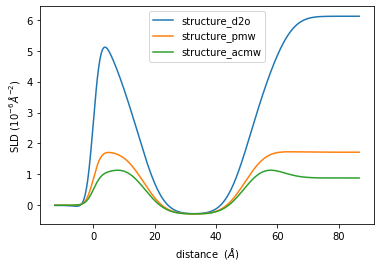

In [16]:
# structure_d2o
# structure_pmw
plt.plot(*structure_d2o.sld_profile(),label="structure_d2o")
# structure_d2o.plot()
# plt.ylabel('SLD ($10^{-6} \AA^{-2})$')
# plt.xlabel('distance  $(\AA)$')

plt.plot(*structure_pmw.sld_profile(),label="structure_pmw")
# structure_pmw.plot()
plt.ylabel('SLD ($10^{-6} \AA^{-2})$')
plt.xlabel('distance  $(\AA)$')

plt.plot(*structure_acmw.sld_profile(),label="structure_acmw")
# structure_pmw.plot()
# plt.ylabel('SLD ($10^{-6} \AA^{-2})$')
# plt.xlabel('distance  $(\AA)$')
plt.legend()
plt.show();

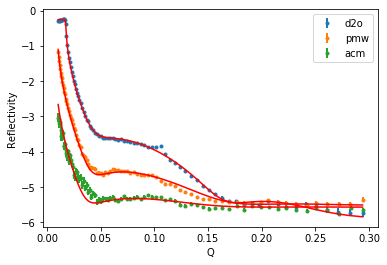

In [17]:
if choose==1:
    gobjective.plot(samples=300)
else:
    gobjective.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

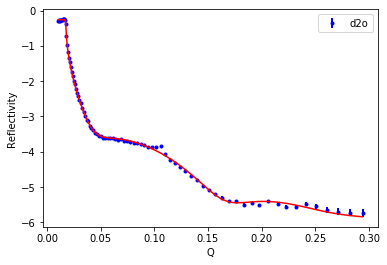

In [18]:
if choose==1:
    objective1.plot(samples=300)
else:
    objective1.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

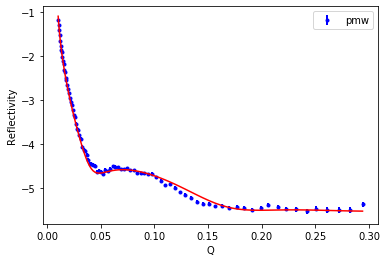

In [19]:
if choose==1:
    objective2.plot(samples=300)
else:
    objective2.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

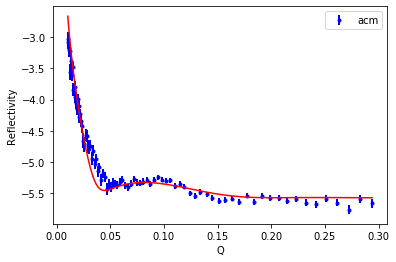

In [20]:
if choose==1:
    objective3.plot(samples=300)
else:
    objective3.plot()
# plt.yscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

In [21]:
print("model1: d2o", model1.scale, model1.bkg)
print("model2: pmw", model2.scale, model2.bkg)
# print("model3: acmw", model3.scale, model3.bkg)

model1: d2o <Parameter:    'scale'    , value=0.549203          , bounds=[0, 1]> <Parameter:     'bkg'     , value=1.11351e-06          , bounds=[3.6e-07, 3.24e-06]>
model2: pmw <Parameter:    'scale'    , value=0.611691          , bounds=[0, 1]> <Parameter:     'bkg'     , value=3.03617e-06          , bounds=[6.040000000000001e-07, 5.436e-06]>


In [22]:
# print(structure_d2o)

In [23]:
# print(structure_pmw)

In [24]:
# print(structure_acmw)

In [25]:
print(structure_d2o.slabs())

[[ 0.          0.          0.          0.          0.        ]
 [ 6.29405381  6.11271013  0.          1.90172401  0.        ]
 [ 9.92808755  3.62678074  0.          5.54650175  0.        ]
 [16.65079682 -0.2810841   0.          5.54650175  0.        ]
 [16.65079682 -0.2810841   0.          5.54650175  0.        ]
 [ 9.92808755  3.62678074  0.          5.54650175  0.        ]
 [ 6.29405381  6.11271013  0.          5.54650175  0.        ]]


In [26]:
print(structure_pmw.slabs())

[[ 0.          0.          0.          0.          0.        ]
 [ 6.29405381  1.71760224  0.          1.90172401  0.        ]
 [ 9.92808755  1.82592739  0.          5.54650175  0.        ]
 [16.65079682 -0.28249666  0.          5.54650175  0.        ]
 [16.65079682 -0.28249666  0.          5.54650175  0.        ]
 [ 9.92808755  1.82592739  0.          5.54650175  0.        ]
 [ 6.29405381  1.71760224  0.          5.54650175  0.        ]]


In [27]:
print(structure_acmw.slabs())

[[ 0.          0.          0.          0.          0.        ]
 [ 6.29405381  0.88394607  0.          1.90172401  0.        ]
 [ 9.92808755  1.48434476  0.          5.54650175  0.        ]
 [16.65079682 -0.28276459  0.          5.54650175  0.        ]
 [16.65079682 -0.28276459  0.          5.54650175  0.        ]
 [ 9.92808755  1.48434476  0.          5.54650175  0.        ]
 [ 6.29405381  0.88394607  0.          5.54650175  0.        ]]


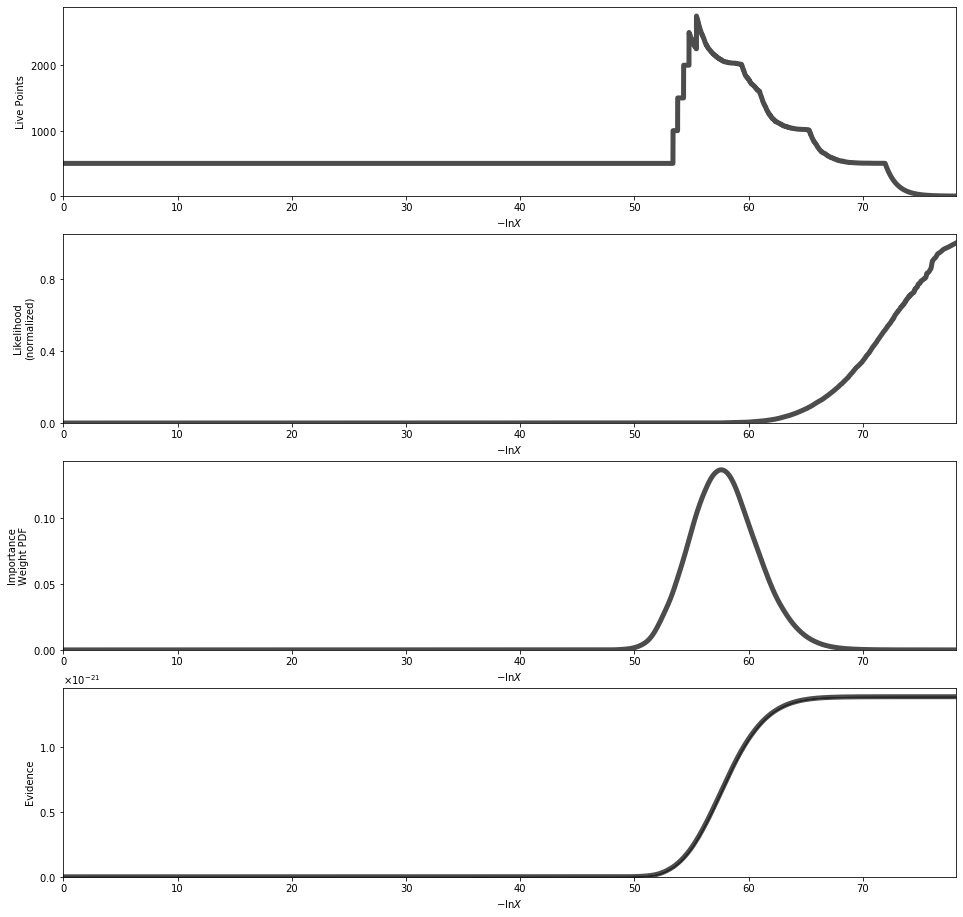

In [28]:
if choose==2:
    # span = [(0,5000),(0,1.5),(0,0.4),(-10**3,10**3)] #span=span
    fig, axes = dyplot.runplot(res1, color='black', mark_final_live=False,
                               logplot=False)

In [29]:
if choose==2:
    print("max(-ln(X)) =", -min(res1["logvol"])) # -min(res1["logvol"] = max(-ln(X))
    print("max(logz), evidence =", max(res1["logz"]))

max(-ln(X)) = 78.1566601780034
max(logz), evidence = -48.02477423636887


In [30]:
#gobjective.varying_parameters()
print("logp:",gobjective.logp())
print("logpost:",gobjective.logpost())
print("model1: d2o", model1.scale, model1.bkg)
print("model2: pmw", model2.scale, model2.bkg)
print("model3: acmw", model3.scale, model3.bkg)
print()
# [[print(i,param.name+":",param.value, param.bounds)] for i,param in enumerate(gobjective.varying_parameters())];
[[print(i,param.name+":",param.value, param.bounds,"logp:", param.logp())] for i,param in enumerate(gobjective.varying_parameters())];
print()
# list(print(p) for p in f_unique(flatten(gobjective.parameters)) if "thi" in p.name or "ap" in p.name);
# volfrac_head = dodab_d2o.vm_heads.value / (dodab_d2o.apm.value *
#                                  dodab_d2o.thickness_heads.value)
# volfrac_tail = dodab_d2o.vm_tails.value / (dodab_d2o.apm.value *
#                                  dodab_d2o.thickness_tails.value)
# print("volfrac_head:",volfrac_head,"volfrac_tail:", volfrac_tail)

volfrac_head = upper_lipid_d2o.vm_heads.value / (upper_lipid_d2o.apm.value *
                                 upper_lipid_d2o.thickness_heads.value)
volfrac_tail = upper_lipid_d2o.vm_tails.value / (upper_lipid_d2o.apm.value *
                                 upper_lipid_d2o.thickness_tails.value)
print("volfrac_head:",volfrac_head,"volfrac_tail:", volfrac_tail)

logp: -21.226985478135568
logpost: -6.06666508508588
model1: d2o <Parameter:    'scale'    , value=0.549203          , bounds=[0, 1]> <Parameter:     'bkg'     , value=1.11351e-06          , bounds=[3.6e-07, 3.24e-06]>
model2: pmw <Parameter:    'scale'    , value=0.611691          , bounds=[0, 1]> <Parameter:     'bkg'     , value=3.03617e-06          , bounds=[6.040000000000001e-07, 5.436e-06]>
model3: acmw <Parameter:    'scale'    , value=0.143298          , bounds=[0, 1]> <Parameter:     'bkg'     , value=2.66825e-06          , bounds=[3.46e-07, 3.114e-06]>

0 scale: 0.5492029569826198 [0, 1] logp: 0.0
1 bkg: 1.1135056531628248e-06 [3.6e-07, 3.24e-06] logp: 12.75772026381642
2 thickness_solution: 6.294053809403377 [6, 25] logp: -2.9444389791664407
3 D2O - sld: 6.112710130776451 [5.35, 6.35] logp: 0.0
4 rough_preceding_solution: 1.9017240059823335 [0, 20] logp: -2.995732273553991
5 bilayer - area_per_molecule: 56.48378344239201 [25, 100] logp: -4.31748811353631
6 bilayer - thicknes

logp: -inf
logpost: -inf
model1: d2o <Parameter:    'scale'    , value=0.549101          , bounds=[0.5, 0.65]> <Parameter:     'bkg'     , value=1.18496e-06          , bounds=[3.6e-07, 3.24e-06]>
model2: pmw <Parameter:    'scale'    , value=0.648749          , bounds=[0.5, 0.65]> <Parameter:     'bkg'     , value=3.17084e-06          , bounds=[6.040000000000001e-07, 5.436e-06]>

0 scale: 0.5491013265084062 [0.5, 0.65] logp: 1.8971199848858813
1 bkg: 1.1849578556868552e-06 [3.6e-07, 3.24e-06] logp: 12.75772026381642
2 thickness_solution: 9.0852153265866 [6, 25] logp: -2.9444389791664407
3 D2O - sld: 6.113002080900383 [5.35, 6.35] logp: 0.0
4 rough_preceding_solution: 2.1693995542364326 [0, 20] logp: -2.995732273553991
5 bilayer - area_per_molecule: 56.49160574805357 [25, 100] logp: -4.31748811353631
6 bilayer - thickness_heads: 7.518907079603842 [1, 30] logp: -3.367295829986474
7 bilayer - thickness_tails: 16.35989423147224 [1, 30] logp: -3.367295829986474
8 bilayer - roughs: 6.755636916212968 [0, 10] logp: -2.3025850929940455
9 scale: 0.6487485593444838 [0.5, 0.65] logp: 1.8971199848858813
10 bkg: 3.170835357649038e-06 [6.040000000000001e-07, 5.436e-06] logp: 12.24025009733176
11 Protein Matched Water - sld: 1.6930326557107866 [1.35, 3.35] logp: -0.6931471805599453

volfrac_head: 0.779272510665993 volfrac_tail: 1.0173159080554188

logp: -10.490609088087473\
logpost: 17.62268089261965\
model1: d2o <Parameter:    'scale'    , value=0.549228 +/- 0.00156, bounds=[0.5, 0.65]> <Parameter:     'bkg'     , value=1.22697e-06 +/- 2.68e-07, bounds=[3.6e-07, 3.24e-06]>\
model2: pmw <Parameter:    'scale'    , value=0.649761 +/- 0.0322, bounds=[0.5, 0.65]> <Parameter:     'bkg'     , value=3.0741e-06 +/- 8.74e-08, bounds=[6.040000000000001e-07, 5.436e-06]>\

0 scale: 0.5492281647969319 [0.5, 0.65] logp: 1.8971199848858813\
1 bkg: 1.226965651203409e-06 [3.6e-07, 3.24e-06] logp: 12.75772026381642\
2 thickness_solution: 8.305179241524081 [6, 25] logp: -2.9444389791664407\
3 D2O - sld: 6.112183186229328 [5.35, 6.35] logp: 0.0\
4 rough_preceding_solution: 2.2877953415685726 [0, 20] logp: -2.995732273553991\
5 bilayer - area_per_molecule: 56.93865886215209 [25, 100] logp: -4.31748811353631\
6 bilayer - thickness_heads: 7.97904560551147 [1, 30] logp: -3.367295829986474\
7 bilayer - thickness_tails: 16.513065027262286 [1, 30] logp: -3.367295829986474\
8 bilayer - roughs: 6.0609769145636285 [0, 10] logp: -2.3025850929940455\
9 scale: 0.6497612329758051 [0.5, 0.65] logp: 1.8971199848858813\
10 bkg: 3.074103742304922e-06 [6.040000000000001e-07, 5.436e-06] logp: 12.24025009733176\
11 Protein Matched Water - sld: 1.6875704213514187 [1.35, 3.35] logp: -0.6931471805599453\

volfrac_head: 0.7285675312015728 volfrac_tail: 0.9999662036993213

In [31]:
print(#upper_lipid_d2o.total_vm(),"\n",
# upper_lipid_d2o.sld_r(),"\n",
float(upper_lipid_d2o.b_heads_real) / float(upper_lipid_d2o.vm_heads.value) * 1.e6,"\n",
float(upper_lipid_d2o.b_tails_real) / float(upper_lipid_d2o.vm_tails.value) * 1.e6,"\n",
upper_lipid_d2o.b_heads_real,"\n",
upper_lipid_d2o.b_tails_real,"\n")#,
# float(dodab_d2o.b_heads_real) / float(dodab_d2o.vm_heads.value) * 1.e6,"\n",
# float(dodab_d2o.b_tails_real) / float(dodab_d2o.vm_tails.value) * 1.e6,"\n",
# dodab_d2o.b_heads_real,"\n",
# dodab_d2o.b_tails_real,"\n")#,
# upper_lipid_d2o.protien_frac_in_head(),"\n",
# upper_lipid_d2o.protien_frac_in_tail(),"\n",
# upper_lipid_d2o.vm_head(),"\n",
# upper_lipid_d2o.vm_tail(),"\n",
# upper_lipid_d2o.vm_heads,"\n",
# upper_lipid_d2o.vm_tails,"\n",
# upper_lipid_d2o.PLRatio,"\n",
# upper_lipid_d2o.vm_mscl,"\n")
# upper_lipid_d2o.total_vm(),"\n")
# print(upper_lipid_d2o.d2o_mol_fraction_head(),upper_lipid_pmw.d2o_mol_fraction_head())

1.9011329305135953 
 -0.28317379281004046 
 <Parameter:'bilayer - b_heads_real', value=0.000629275 (fixed)  , bounds=[-inf, inf]> 
 <Parameter:'bilayer - b_tails_real', value=-0.00026624 (fixed)  , bounds=[-inf, inf]> 



<!-- I believe correct values, leaflet roughness between head and tail is the same as the roughness preceeding the leaflet\
class used is a modified version of the LipidLeaflet class native to refnx, its in the file\
"protein" and called "LipidLeafletWithProtien"\
volumes of head and tails are indirectly varied by changes in waters per head/tail\
so the tails do not change volume\
0 scale: 0.5521883304658243 [0.5, 0.6]\
1 bkg: 3.8668280301251303e-07 [3.6e-07, 3.24e-06]\
2 thickness_solution: 10.788185214150985 [6, 25]\
3 D2O - sld: 6.120774383877097 [5.35, 6.35]\
4 rough_preceding_solution: 3.939327435493368 [0, 20]\
5 bilayer - area_per_molecule: 149.83843268748353 [60, 150]\
6 bilayer - thickness_heads: 2.2131024442953855 [1, 30]\
7 bilayer - thickness_tails: 19.19114563662231 [1, 30]\
8 bilayer - rough_top: 0.15555337800548585 [0, 10]\
9 bilayer - Waters Per Head: 0.017922237590786594 [0, 20]\
10 bilayer - Waters Per Tail: 0.02927203409960022 [0, 10]\
11 bilayer - ratio protein to bilayer: 0.7498017765068212 [0.25, 0.75]\
12 Protrusion - protrusion thickness: 6.090177488208205 [5, 100]\
13 Protrusion - protrusion roughness: 7.445463122283828 [0, 20]\
14 Protrusion - protrusion volfrac: 0.9963095809664922 [0, 1]\
15 scale: 0.5990025735918081 [0.5, 0.6]\
16 bkg: 3.5880504074107574e-06 [6.040000000000001e-07, 5.436e-06]\
17 Protein Matched Water - sld: 1.757984633375042 [1.35, 3.35]\
18 scale: 0.5907367476195101 [0.5, 0.6]\
19 bkg: 2.831535701386751e-06 [3.46e-07, 3.114e-06]\
20 ACMW - sld: 0.4132210895757328 [-0.56, 1] -->

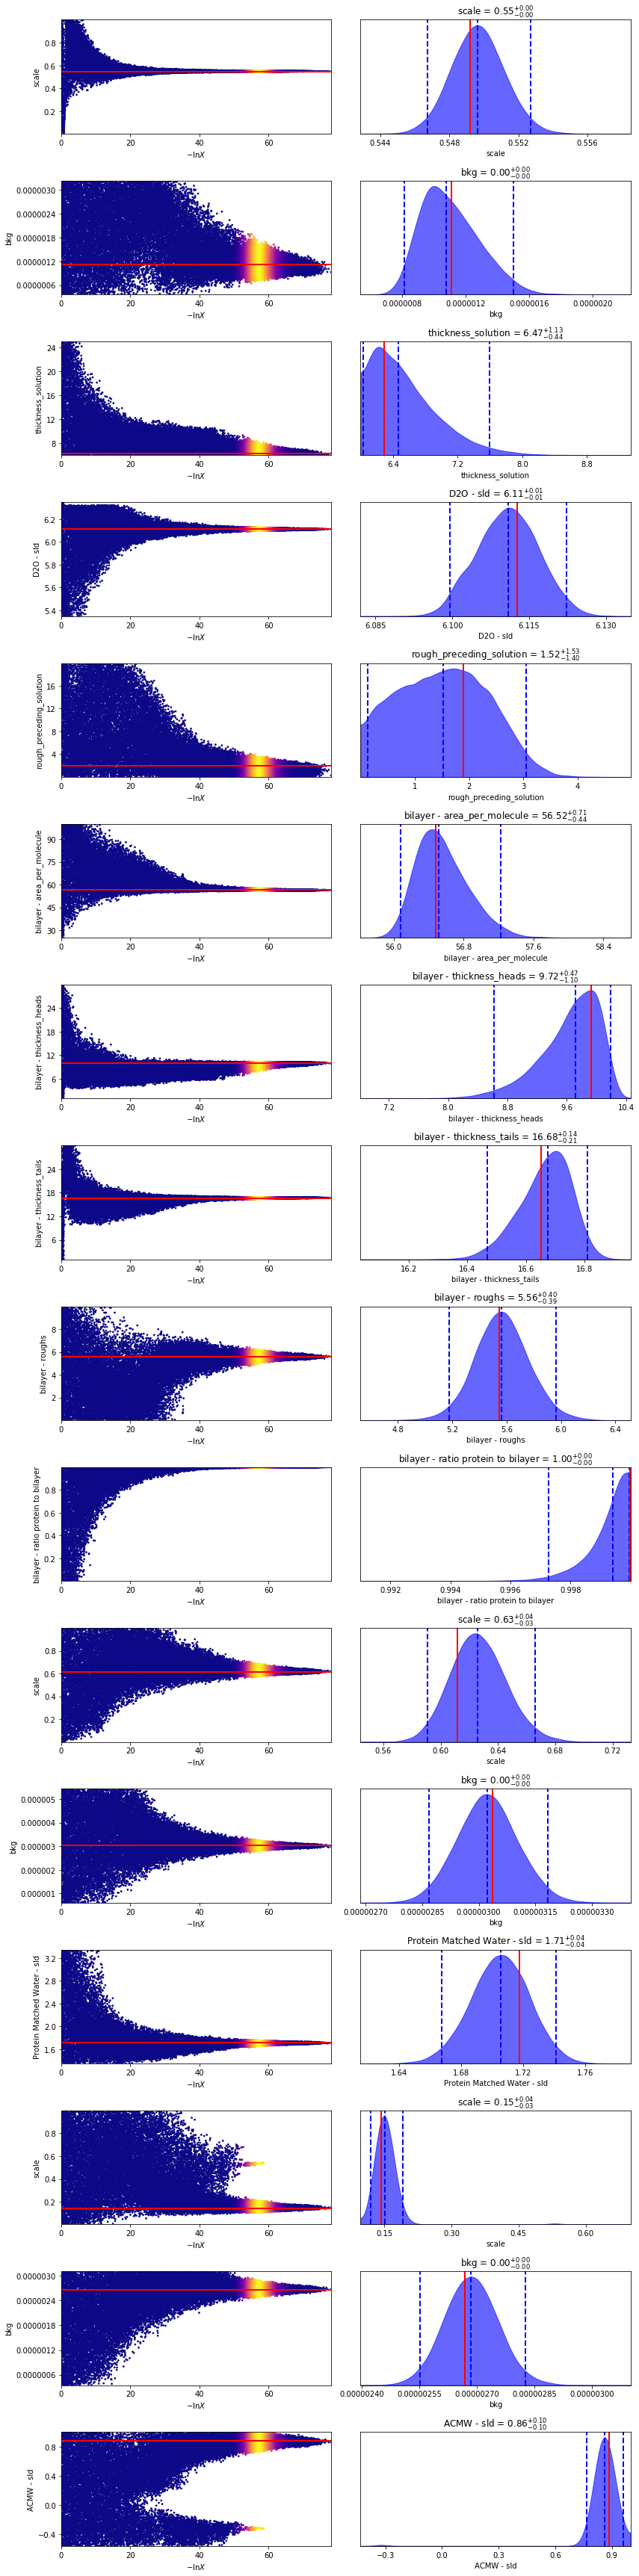

In [32]:
if choose==2:
    labels = [param.name for param in gobjective.varying_parameters()]

    fig, axes = dyplot.traceplot(res1, labels = labels, truths=[param.value for param in gobjective.varying_parameters()],
                                 show_titles=True, trace_cmap='plasma',
                                 quantiles=[0.025, 0.5, 0.975])
    fig.tight_layout()

In [33]:
# if choose==2:
#     labels = [param.name for param in gobjective.varying_parameters()]
# #     dim = [0,2,3,4,5,6,7,8,9,1]
#     fig, axes = dyplot.cornerpoints(res1,labels = labels,truths=[param.value for param in gobjective.varying_parameters()],
#                                  #show_titles=True,
#                                  #trace_cmap='plasma',
#                                  #quantiles=[0.025, 0.5, 0.975]
#                                    )
#     fig.tight_layout()

In [34]:
# if choose==2:
#     labels = [param.name for param in gobjective.varying_parameters()]

#     fig, axes = dyplot.cornerplot(res1, labels = labels,truths=[param.value for param in gobjective.varying_parameters()],
#                                  #show_titles=True,
#                                  #trace_cmap='plasma',
#                                  #quantiles=[0.025, 0.5, 0.975]
#                                    )
#     fig.tight_layout()

In [35]:
# if choose==2:
#     labels = [param.name for param in gobjective.varying_parameters()if not "bkg" in param.name]
#     dim = [0,2,3,4,5,6,7,8,9,11]
#     fig, axes = dyplot.cornerpoints(res1,dims=dim, labels = labels,truths=[param.value for param in gobjective.varying_parameters() if not "bkg" in param.name],
#                                  #show_titles=True,
#                                  #trace_cmap='plasma',
#                                  #quantiles=[0.025, 0.5, 0.975]
#                                    )
#     fig.tight_layout()

In [36]:
# if choose==2:
#     labels = [param.name for param in gobjective.varying_parameters() if not "bkg" in param.name]
# #     labels = [label for label in labels ]
#     dim = [0,2,3,4,5,6,7,8,9,11]
#     fig, axes = dyplot.cornerplot(res1,dims=dim, labels = labels,truths=[param.value for param in gobjective.varying_parameters() if not "bkg" in param.name],
#                                  #show_titles=True,
#                                  #trace_cmap='plasma',
#                                  #quantiles=[0.025, 0.5, 0.975]
#                                    )
#     fig.tight_layout()